# 1. Título: Compras Públicas do Governo Federal

# 2. Membros:

Daniel Augusto Castro de Paula - 2022060550

Diego Roberto das Chagas - 2021019718

Gabriel Vilhena Menetryer - 2022038538


# 3. Descrição dos dados:


Este trabalho foi desenvolvido com base nos dados públicos disponibilizados no [portal do Governo](https://dados.gov.br/dados/conjuntos-dados/compras-publicas-do-governo-federal), especificamente no conjunto de dados "Compras públicas do Governo Federal". Esses dados são fornecidos pelo Governo Federal e refletem informações detalhadas sobre os processos de aquisição de bens e serviços realizados por órgãos e entidades da administração pública.

O conjunto de dados original foi extraído de duas planilhas, uma contendo dados a cerca das compras que foram iniciadas ou tiveram alguma atualização no mês de junho de 2025, e outra contendo informações sobre os itens adquiridos nas compras. Essas planilhas contém registros estruturados das compras governamentais, como: itens adquiridos, modalidades de licitação, fornecedores, valores estimados e homologados, datas de publicação e as unidades gestoras responsáveis pelas compras.

O processamento dos dados foi realizado extraindo dos dados originais um subconjunto adequado para o esquema relacional definido, limpando informações desnecessárias e sem utilidade para a análise em questão.

## 3.1 Processamento dos dados

In [1]:
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# consultas para ajudar a visualizar os dados

def fetch(query, conn, formatted=True):
    # executa a consulta e recupera todas as linhas
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()

    # extrai os nomes das colunas da descrição do cursor
    columns = [desc[0] for desc in cur.description]

    # retorna um DataFrame com os nomes das colunas
    return pd.DataFrame(rs, columns=columns) if formatted else rs


def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]


def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)


def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]

    return columns


def info(table, conn):
    # restrições da tabela (domínio, nulo, padrão, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)

    # entradas por coluna
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']

    # entradas não nulas por coluna
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # entradas não nulas e únicas por coluna
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']

    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def hist(data, xlabel='', ylabel='', bins='auto'):
    # converte lista de tuplas em DataFrame
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expande os dados com base nas frequências
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plota histograma
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

In [3]:
# ingestão dos dados

# Caminhos dos arquivos CSV no Drive
source_compras = '/content/drive/MyDrive/comprasGOV-mensal-VW_FT_PNCP_COMPRA-latest.csv'
source_itens   = '/content/drive/MyDrive/comprasGOV-mensal-VW_FT_PNCP_COMPRA_ITEM-latest.csv'

# Conexão com o banco SQLite
conn = sqlite3.connect('tp2.db')
cur = conn.cursor()

# Desativa validação de chaves estrangeiras e ajusta PRAGMA para acelerar ingestão
cur.execute('PRAGMA foreign_keys = 0')
cur.execute('PRAGMA synchronous = OFF')
cur.execute('PRAGMA journal_mode = MEMORY')

# Tamanho de lote para processamento em massa
BATCH_SIZE = 1000

# Função genérica para ingestão de CSV em tabela SQLite
def ingest_csv(source, table_name):
    cur.execute('BEGIN TRANSACTION')
    with open(source, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)
        columns = [f'"{col}" TEXT' for col in header]

        # Cria tabela se não existir
        cur.execute(f'CREATE TABLE IF NOT EXISTS {table_name} ({", ".join(columns)})')

        # Prepara comando de inserção com placeholders
        placeholders = ','.join(['?'] * len(header))
        insert_sql = f'INSERT INTO {table_name} VALUES ({placeholders})'

        # Processa linhas em lotes
        batch = []
        for row in reader:
            batch.append(row)
            if len(batch) >= BATCH_SIZE:
                cur.executemany(insert_sql, batch)
                batch = []
        if batch:
            cur.executemany(insert_sql, batch)

    # Converte strings vazias para NULL para consistência
    cols = [f'"{col}"' for col in header]
    update_sql = f'UPDATE {table_name} SET ' + ','.join([f'{col} = NULLIF({col}, "")' for col in cols])
    cur.execute(update_sql)
    conn.commit()

# Ingestão das duas tabelas brutas
ingest_csv(source_compras, 'dados_brutos_compras')
ingest_csv(source_itens,   'dados_brutos_itens')

# Restaura configurações originais do SQLite
cur.execute('PRAGMA synchronous = FULL')
cur.execute('PRAGMA journal_mode = DELETE')
cur.execute('PRAGMA foreign_keys = 1')

show_tables(conn)

['dados_brutos_compras', 'dados_brutos_itens']

In [4]:
info('dados_brutos_compras', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,cod_compra,TEXT,0,None,0,7257,7257,7257
1,1,modalidade_id,TEXT,0,None,0,7257,7257,8
2,2,modo_disputa_id,TEXT,0,None,0,7257,7257,6
3,3,id_compra,TEXT,0,None,0,7257,7257,7257
4,4,ind_atual,TEXT,0,None,0,7257,7257,1
5,5,valor_total_estimado,TEXT,0,None,0,7257,7257,5297
6,6,valor_total_homologado,TEXT,0,None,0,7257,2445,1713
7,7,orgao_subrogado_cnpj,TEXT,0,None,0,7257,28,13
8,8,orgao_subrogado_razao_social,TEXT,0,None,0,7257,28,13
9,9,orgao_subrogado_esfera_id,TEXT,0,None,0,7257,28,2


In [5]:
info('dados_brutos_itens', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,srk_pncp_item_compra,TEXT,0,None,0,116974,116974,110837
1,1,cod_compra,TEXT,0,None,0,116974,116974,11194
2,2,cod_item_compra,TEXT,0,None,0,116974,116974,110837
3,3,codigo_classe,TEXT,0,None,0,116974,38318,362
4,4,codigo_grupo,TEXT,0,None,0,116974,7649,95
5,5,numero_item,TEXT,0,None,0,116974,116974,1630
6,6,numero_grupo,TEXT,0,None,0,116974,116974,1
7,7,numero_item_compra,TEXT,0,None,0,116974,116974,1630
8,8,descricao_detalhada,TEXT,0,None,0,116974,47642,27705
9,9,descricao,TEXT,0,None,0,116974,116974,12726


In [6]:
# limpeza dos dados brutos

# ao fazer a análise dos dados percebemos que alguns itens estavam com cod_item_catalogo vazios
# iremos excluir todos registros das compras em que algum item foi lançado com seu código vazio

# apagar os registros das compras que tem item null
cur.execute("""
    DELETE FROM dados_brutos_compras
    WHERE cod_compra IN (
        SELECT DISTINCT cod_compra
        FROM dados_brutos_itens
        WHERE cod_item_catalogo IS NULL
    );
""")

# apagar os itens das compras em que algum item tem valor null
cur.execute("""
    DELETE FROM dados_brutos_itens
    WHERE cod_compra IN (
        SELECT cod_compra
        FROM dados_brutos_itens
        WHERE cod_item_catalogo IS NULL
    );
""")

# confirma as deleções
conn.commit()

# compras sem itens associados, acontece quando o processo de compra iniciou porém não foi definido os itens ainda
fetch('SELECT c.cod_compra FROM dados_brutos_compras AS c WHERE c.cod_compra NOT IN (SELECT DISTINCT i.cod_compra FROM dados_brutos_itens AS i)', conn)

# deleta compras que não têm itens associados
cur.execute("DELETE FROM dados_brutos_compras WHERE cod_compra NOT IN (SELECT DISTINCT cod_compra FROM dados_brutos_itens)")

# itens sem compra correspondente
fetch('SELECT DISTINCT i.cod_compra FROM dados_brutos_itens AS i WHERE i.cod_compra NOT IN (SELECT c.cod_compra FROM dados_brutos_compras AS c)', conn)

# deleta itens que não têm compra correspondente, esses casos acontece quando o processo de compra começou em meses anteriores sem ser o de junho
cur.execute("DELETE FROM dados_brutos_itens WHERE cod_compra NOT IN (SELECT cod_compra FROM dados_brutos_compras)")


In [7]:
# criação tabelas  novas para normalização

ddl = [
    '''
    CREATE TABLE IF NOT EXISTS Unidade_gestora (
        unidade_orgao_codigo_unidade INTEGER PRIMARY KEY,
        unidade_orgao_nome_unidade TEXT NOT NULL,
        unidade_orgao_uf_sigla TEXT NOT NULL,
        unidade_orgao_municipio_nome TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Modalidade (
        modalidade_id INTEGER PRIMARY KEY,
        codigo_modalidade INTEGER NOT NULL,
        modalidade_nome TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Compra (
        cod_compra INTEGER PRIMARY KEY,
        data_publicacao_pncp TEXT,
        data_atualizacao TEXT,
        valor_total_estimado REAL,
        valor_total_homologado REAL,
        objeto_compra TEXT,
        modalidade_id INTEGER NOT NULL,
        unidade_orgao_codigo_unidade TEXT NOT NULL,
        FOREIGN KEY (modalidade_id) REFERENCES Modalidade(modalidade_id),
        FOREIGN KEY (unidade_orgao_codigo_unidade) REFERENCES Unidade_gestora(unidade_orgao_codigo_unidade)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Item (
        cod_item_catalogo INTEGER PRIMARY KEY,
        material_ou_servico_nome TEXT,
        descricao TEXT,
        descricao_detalhada TEXT
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Itens_compra (
        cod_compra INTEGER NOT NULL,
        cod_item_catalogo INTEGER NOT NULL,
        quantidade INTEGER,
        PRIMARY KEY (cod_compra, cod_item_catalogo),
        FOREIGN KEY (cod_compra) REFERENCES Compra(cod_compra),
        FOREIGN KEY (cod_item_catalogo) REFERENCES Item(cod_item_catalogo)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Fornecedor (
        cod_fornecedor TEXT PRIMARY KEY,
        nome_fornecedor TEXT
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Fornecedor_item (
        cod_fornecedor TEXT NOT NULL,
        cod_item_catalogo INTEGER NOT NULL,
        PRIMARY KEY (cod_fornecedor, cod_item_catalogo),
        FOREIGN KEY (cod_fornecedor) REFERENCES Fornecedor(cod_fornecedor),
        FOREIGN KEY (cod_item_catalogo) REFERENCES Item(cod_item_catalogo)
    );
    '''
]

for sql in ddl:
    cur.execute(sql)

# Confirma criação das tabelas
conn.commit()

show_tables(conn)

['dados_brutos_compras',
 'dados_brutos_itens',
 'Unidade_gestora',
 'Modalidade',
 'Compra',
 'Item',
 'Itens_compra',
 'Fornecedor',
 'Fornecedor_item']

In [8]:
# popular Unidade_gestora
cur.execute("DELETE FROM Unidade_gestora")

cur.execute("""
INSERT INTO Unidade_gestora (
    unidade_orgao_codigo_unidade,
    unidade_orgao_nome_unidade,
    unidade_orgao_uf_sigla,
    unidade_orgao_municipio_nome
)
SELECT
    unidade_orgao_codigo_unidade,
    unidade_orgao_nome_unidade,
    unidade_orgao_uf_sigla,
    unidade_orgao_municipio_nome
FROM dados_brutos_compras
GROUP BY unidade_orgao_codigo_unidade;
""")

# verificar os dados inseridos em Unidade_gestora
fetch("SELECT * FROM Unidade_gestora ", conn)


,unidade_orgao_codigo_unidade,unidade_orgao_nome_unidade,unidade_orgao_uf_sigla,unidade_orgao_municipio_nome
0,10001,CAMARA DOS DEPUTADOS,DF,BRASÍLIA
1,20001,SENADO FEDERAL,DF,BRASÍLIA
2,30001,TCU-TRIBUNAL DE CONTAS DA UNIAO/DF,DF,BRASÍLIA
3,30100,TRIBUNAL DE JUSTICA DO ESTADO DO RJ,RJ,RIO DE JANEIRO
4,30203,INSTITUTO SERZEDELLO CORREA - ISC/TCU,DF,BRASÍLIA
...,...,...,...,...
1431,990144,ESP-FED-APTA REGIONAL,SP,CAMPINAS
1432,990145,ESP-FED-CATI SEMENTES E MUDAS,SP,CAMPINAS
1433,990147,ESP-FED-COORD.DEFESA AGROPECUARIA,SP,CAMPINAS
1434,990174,ESP-FED PRES.BIODIV.E DOS REC.NATURAIS-FPBR,SP,SÃO PAULO


In [9]:
# popular Modalidade
cur.execute("DELETE FROM Modalidade")

cur.execute("""
INSERT INTO Modalidade (
    modalidade_id,
    codigo_modalidade,
    modalidade_nome
)
SELECT
    modalidade_id,
    codigo_modalidade,
    modalidade_nome
FROM dados_brutos_compras
GROUP BY modalidade_id;
""")

# verificar os dados inseridos em Modalidade
fetch("SELECT * FROM Modalidade", conn)


,modalidade_id,codigo_modalidade,modalidade_nome
0,4,3,Concorrência - Eletrônica
1,5,3,Concorrência - Presencial
2,6,5,Pregão - Eletrônico
3,7,5,Pregão - Presencial
4,8,6,Dispensa
5,9,7,Inexigibilidade


In [10]:
# popular Compra
cur.execute("DELETE FROM Compra")

cur.execute("""
INSERT INTO Compra (
    cod_compra,
    data_publicacao_pncp,
    data_atualizacao,
    valor_total_estimado,
    valor_total_homologado,
    objeto_compra,
    modalidade_id,
    unidade_orgao_codigo_unidade
)
SELECT
    cod_compra,
    data_publicacao_pncp,
    data_atualizacao,
    valor_total_estimado,
    valor_total_homologado,
    objeto_compra,
    modalidade_id,
    unidade_orgao_codigo_unidade
FROM dados_brutos_compras
GROUP BY cod_compra;
""")

# verificar os dados inseridos em Compra
fetch("SELECT * FROM Compra", conn)


,cod_compra,data_publicacao_pncp,data_atualizacao,valor_total_estimado,valor_total_homologado,objeto_compra,modalidade_id,unidade_orgao_codigo_unidade
0,5494619,2023-08-17 07:01:45,2025-06-03 09:28:26,0.000000e+00,NaN,Aquisição de rádios comunicadores,6,153028
1,5867782,2024-03-20 16:46:46,2025-06-03 09:21:44,1.200000e+03,1.200000e+03,"Despesa com serviço de coleta, transporte, tra...",8,160078
2,5968630,2024-04-16 07:06:27,2025-06-02 08:37:40,6.243186e+05,5.780832e+05,Registro de preços para aquisições de aparelho...,6,988461
3,6476796,2024-07-08 21:15:08,2025-06-02 17:47:23,1.200000e+08,1.200000e+08,Concorrência nacional para a contratação de tr...,5,927988
4,6733742,2024-08-13 14:09:46,2025-06-04 13:03:44,2.827999e+06,2.540000e+06,Contratação De Empresa Especializada Para Exec...,5,930800
...,...,...,...,...,...,...,...,...
3416,8727791,2025-06-06 20:49:23,2025-06-06 20:49:23,7.416000e+04,7.416000e+04,Pagamento de 12 (doze) inscrições e mais 03 (t...,9,456961
3417,8727839,2025-06-06 21:27:19,2025-06-06 21:27:19,6.263000e+04,6.263000e+04,Contratação de serviços especializados para re...,8,925054
3418,8727863,2025-06-06 21:44:32,2025-06-06 21:44:32,1.500000e+03,NaN,Manutenção de Bomba Hidráulica com substituiçã...,8,160401
3419,8727964,2025-06-06 23:01:41,2025-06-06 23:01:41,9.720000e+04,9.720000e+04,Contratação de serviços de consultoria técnica...,9,925054


In [11]:
# popular Item
cur.execute("DELETE FROM Item")

cur.execute("""
INSERT INTO Item (
    cod_item_catalogo,
    material_ou_servico_nome,
    descricao,
    descricao_detalhada
)
SELECT
    cod_item_catalogo,
    material_ou_servico_nome,
    descricao,
    descricao_detalhada
FROM dados_brutos_itens
GROUP BY cod_item_catalogo;
""")

# verificar os dados inseridos em Item
fetch("SELECT * FROM Item", conn)


,cod_item_catalogo,material_ou_servico_nome,descricao,descricao_detalhada
0,78,Serviço,Estudos e Projetos de Arquitetura Estudos e Pr...,Estudos e Projetos de Arquitetura Estudos e Pr...
1,116,Serviço,Estudos e Projetos de Meio Ambiente Físico,"RIFLES, NOME: RIFLES"
2,132,Serviço,"Estudos e Projetos de Meio Ambiente, Sócio-Eco...","Estudos e Projetos de Meio Ambiente, Sócio-Eco..."
3,213,Serviço,Estudos e projetos de instalação elétrica Estu...,Estudos e projetos de instalação elétrica Estu...
4,728,Serviço,Auditoria em Área de Administração Auditoria e...,Auditoria em Área de Administração Auditoria e...
...,...,...,...,...
4272,628564,Material,Projétil Munição Arma Fogo aplicação: fuzil e ...,Projétil Munição Arma Fogo aplicação: fuzil e ...
4273,628567,Material,Projétil Munição Arma Fogo aplicação: fuzil e ...,Projétil Munição Arma Fogo aplicação: fuzil e ...
4274,628592,Material,Caneta Esferográfica características adicionai...,Caneta Esferográfica características adicionai...
4275,628593,Material,Caneta Esferográfica características adicionai...,Caneta Esferográfica características adicionai...


In [12]:
# popular Itens_compra
cur.execute("DELETE FROM Itens_compra")

cur.execute("""
INSERT INTO Itens_compra (
    cod_compra,
    cod_item_catalogo,
    quantidade
)
SELECT
    cod_compra,
    cod_item_catalogo,
    SUM(quantidade) AS quantidade
FROM dados_brutos_itens
GROUP BY
    cod_compra,
    cod_item_catalogo;
""")

# verificar os dados inseridos em Itens_compra
fetch("SELECT * FROM Itens_compra", conn)


,cod_compra,cod_item_catalogo,quantidade
0,5494619,302516,30
1,5867782,19380,12
2,5968630,370719,170
3,5968630,373980,3
4,5968630,379700,1
...,...,...,...
6854,8727791,21172,12
6855,8727839,22969,10
6856,8727863,22985,1
6857,8727964,15601,1


In [13]:
# popular Fornecedor
cur.execute("DELETE FROM Fornecedor")

cur.execute("""
INSERT INTO Fornecedor (
    cod_fornecedor,
    nome_fornecedor
)
SELECT
    cod_fornecedor,
    nome_fornecedor
FROM dados_brutos_itens
WHERE cod_fornecedor IS NOT NULL
GROUP BY cod_fornecedor;
""")

# verificar os dados inseridos em Fornecedor
fetch("SELECT * FROM Fornecedor", conn)


,cod_fornecedor,nome_fornecedor
0,000000000,MISSISSIPPI STATE UNIVERSITY
1,00000000000191,BANCO DO BRASIL SA
2,00024397008,DAIANE BOELHOUWER MENEZES
3,00028986001775,ELEVADORES ATLAS SCHINDLER LTDA.
4,00063682000181,SOMITEC SOCIEDADE DE MONTAGENS E INST.TECNICAS...
...,...,...
2217,US453836617,Urbanbox Inc
2218,US840,AB Sciex LLC
2219,USBA20241548437,DIGITAL GOVERNMENT SOCIETY
2220,USEPF611845210,Immuno American Corp


In [14]:
# popular Fornecedor_item
cur.execute("DELETE FROM Fornecedor_item")

cur.execute("""
INSERT INTO Fornecedor_item (
    cod_fornecedor,
    cod_item_catalogo
)
SELECT DISTINCT
    cod_fornecedor,
    cod_item_catalogo
FROM dados_brutos_itens
WHERE cod_fornecedor IS NOT NULL;
""")

# verificar os dados inseridos em Fornecedor_item
fetch("SELECT * FROM Fornecedor_item", conn)


,cod_fornecedor,cod_item_catalogo
0,57978150000191,973
1,04455844000188,3620
2,30822936000169,3913
3,15607013820,3972
4,26267881806,3972
...,...,...
4162,43110677000195,627744
4163,02531128000107,627758
4164,00296549002895,628162
4165,21703495000195,628296


# 4. Diagrama ER

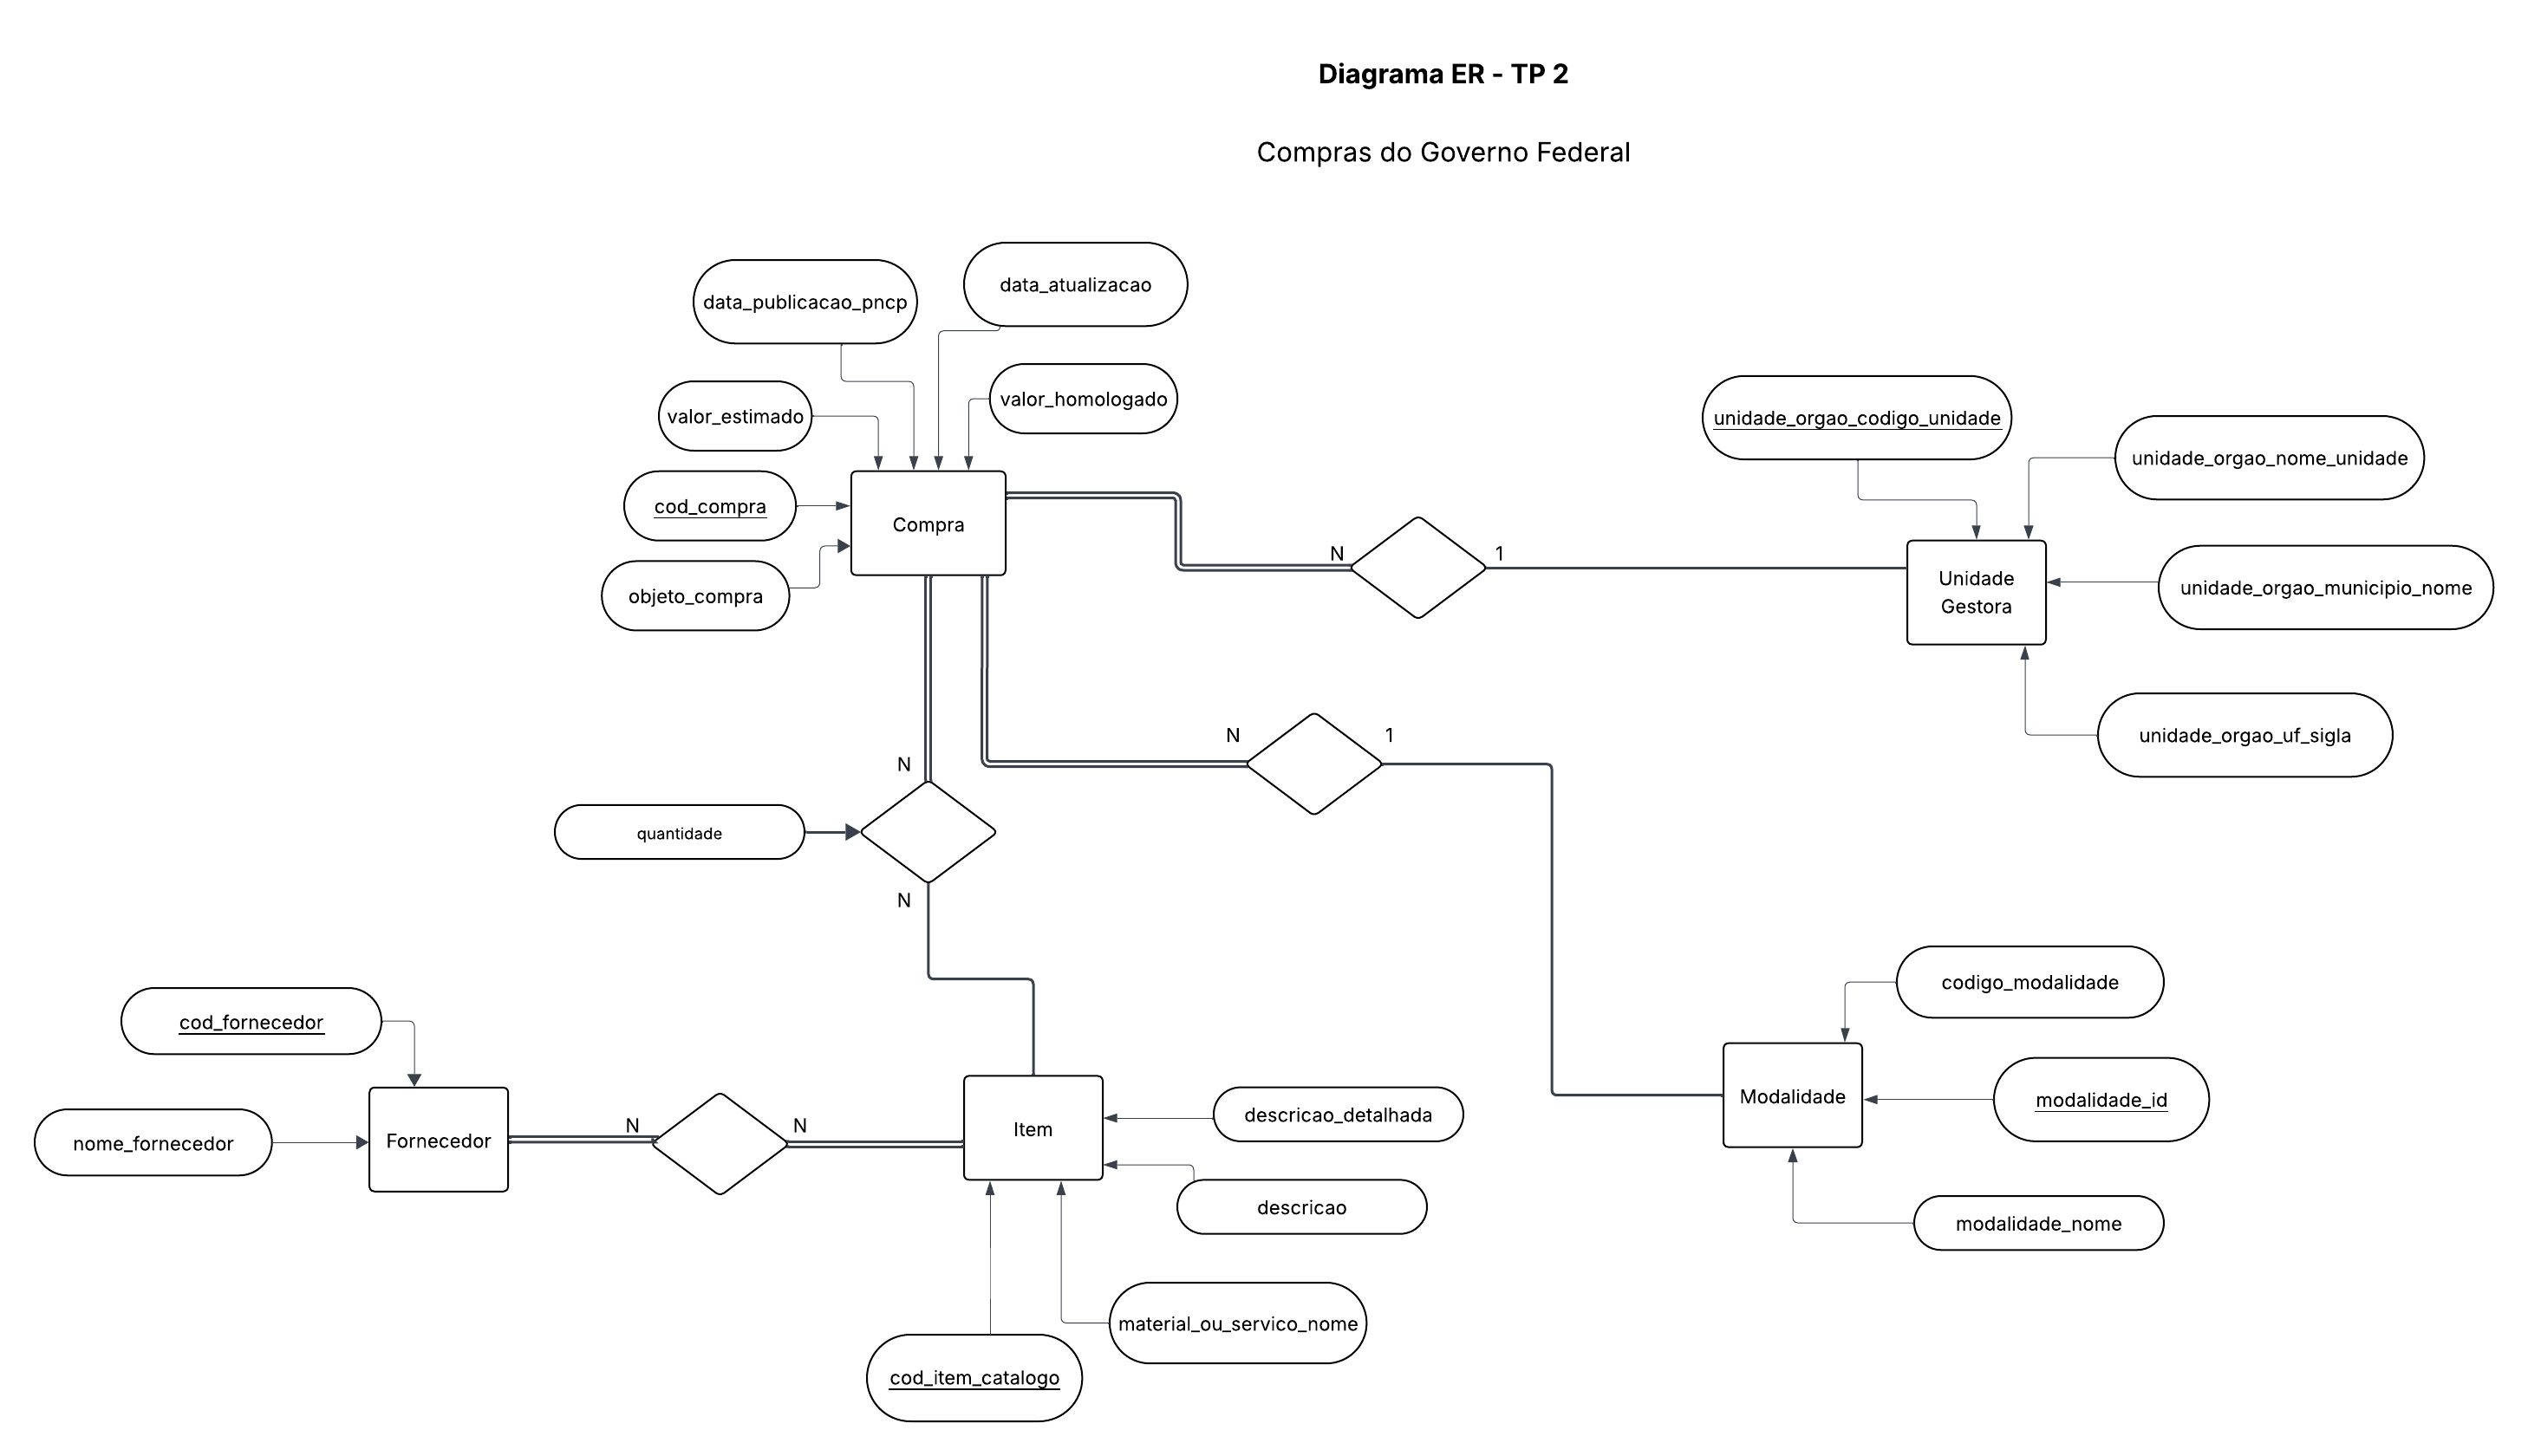

# 5. Diagrama relacional

1- Unidade_gestora (<u>unidade_orgao_codigo_unidade</u>, unidade_orgao_nome_unidade, unidade_orgao_uf_sigla, unidade_orgao_municipio_nome )

2- Modalidade (<u>modalidade_id</u>, codigo_modalidade, modalidade_nome)

3- Compra (<u>cod_compra</u>, data_publicacao_pncp, data_atualizacao, valor_total_estimado, valor_total_homologado, objeto_compra, modalidade_id, unidade_orgao_codigo_unidade)
- modalidade_id referencia Modalidade(modalidade_id) , unidade_orgao_codigo_unidade referencia Unidade_gestora(unidade_orgao_codigo_unidade)

4- Item (<u>cod_item_catalogo</u>, material_ou_servico_nome, descricao, descricao_detalhada)

5- Itens_compra (<u>cod_compra</u>, <u>cod_item_catalogo</u>, quantidade)
- cod_compra referencia Compra(cod_compra), cod_item_catalogo referencia Item(cod_item_catalogo)

6- Fornecedor (<u>cod_fornecedor</u>, nome_fornecedor)

7- Fornecedor_item (<u>cod_fornecedor</u>, <u>cod_item_catalogo</u>)
- cod_fornecedor referencia Fornecedor(cod_fornecedor), cod_item_catalogo referencia Item(cod_item_catalogo)



# 6. Consultas


## 6.1 Consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1

In [15]:
# Compras com valor estimado acima de 1 milhão de reais
fetch("""
SELECT
    cod_compra,
    valor_total_estimado,
    data_atualizacao
FROM Compra
WHERE valor_total_estimado > 1000000;
""", conn)

,cod_compra,valor_total_estimado,data_atualizacao
0,6476796,1.200000e+08,2025-06-02 17:47:23
1,6733742,2.827999e+06,2025-06-04 13:03:44
2,6741546,1.442426e+09,2025-06-04 11:48:38
3,7017419,1.717200e+06,2025-06-03 08:13:27
4,7351411,2.196160e+06,2025-06-02 10:37:05
...,...,...,...
161,8726572,1.031656e+06,2025-06-06 16:41:57
162,8727014,3.909000e+06,2025-06-06 17:29:05
163,8727197,3.760800e+06,2025-06-06 18:07:58
164,8727223,4.166863e+06,2025-06-06 18:15:34


### 6.1.2 Consulta 2

In [16]:
# Nomes unidades gestoras de Minas Gerais (UF = 'MG')
fetch("""
SELECT
    unidade_orgao_codigo_unidade,
    unidade_orgao_nome_unidade,
    unidade_orgao_municipio_nome
FROM Unidade_gestora
WHERE unidade_orgao_uf_sigla = 'MG';
""", conn)

,unidade_orgao_codigo_unidade,unidade_orgao_nome_unidade,unidade_orgao_municipio_nome
0,60006,CJM-AUDITORIA DA 4A. CJM/MG,JUIZ DE FORA
1,70014,TRE-TRIBUNAL REGIONAL ELEITORAL/MG,BELO HORIZONTE
2,80008,TRIBUNAL REGIONAL DO TRABALHO DA 3ª REGIÃO,BELO HORIZONTE
3,90013,JUSTICA FEDERAL DE PRIMEIRO GRAU EM MG,BELO HORIZONTE
4,90059,TRIBUNAL REGIONAL FEDERAL DA 6ª REGIÃO/MG,BELO HORIZONTE
...,...,...,...
74,984445,MUNICÍPIO DE DIVINÓPOLIS,DIVINÓPOLIS
75,984675,PREFEITURA MUNICIPAL DE ITAUNA - MG,ITAÚNA
76,984733,PREFEITURA MUNICIPAL DE JUIZ DE FORA - MG,JUIZ DE FORA
77,984767,PREFEITURA MUNICIPAL DE LEOPOLDINA - MG,LEOPOLDINA


## 6.2 Consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3

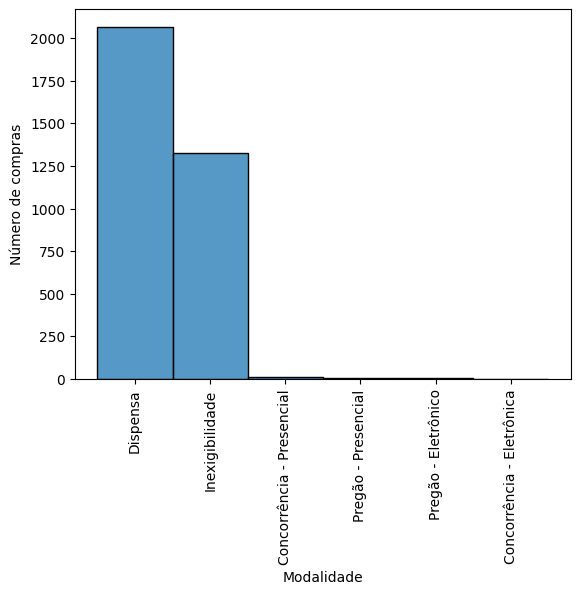

In [17]:
# Distribuição de compras por modalidade
distro_modalidade = fetch("""
SELECT
    m.modalidade_nome   AS modalidade,
    COUNT(*)            AS frequencia
FROM Compra c
INNER JOIN Modalidade m
  ON c.modalidade_id = m.modalidade_id
GROUP BY m.modalidade_nome
ORDER BY frequencia DESC;
""", conn, False)

hist(distro_modalidade,
     xlabel='Modalidade',
     ylabel='Número de compras')

### 6.2.2 Consulta 4

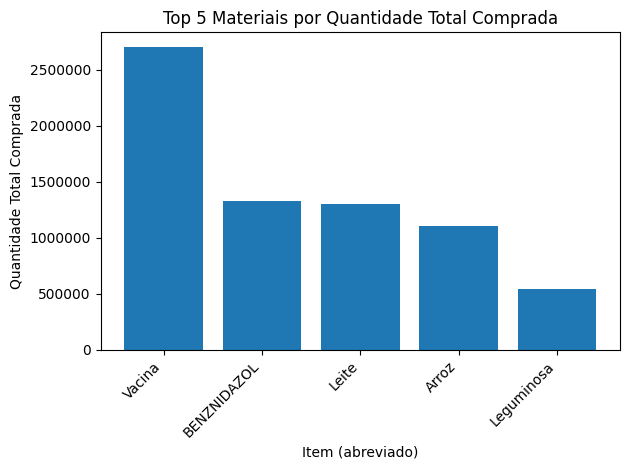

In [18]:
# top 5 materiais por quantidade total comprada
df = fetch("""
SELECT
    i.cod_item_catalogo,
    i.descricao,
    SUM(ic.quantidade) AS total_quantidade
FROM Itens_compra ic
INNER JOIN Item i
  ON ic.cod_item_catalogo = i.cod_item_catalogo
WHERE i.material_ou_servico_nome = 'Material'
GROUP BY
    i.cod_item_catalogo,
    i.descricao
ORDER BY
    total_quantidade DESC
LIMIT 5;
""", conn)

# abreviação: pega o primeiro nome da descrição
df['desc_abrev'] = df['descricao'].str.split().str[0]

# plot
plt.figure()
plt.bar(df['desc_abrev'], df['total_quantidade'])
plt.xlabel('Item (abreviado)')
plt.ylabel('Quantidade Total Comprada')
plt.title("Top 5 Materiais por Quantidade Total Comprada")
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

### 6.2.3 Consulta 5

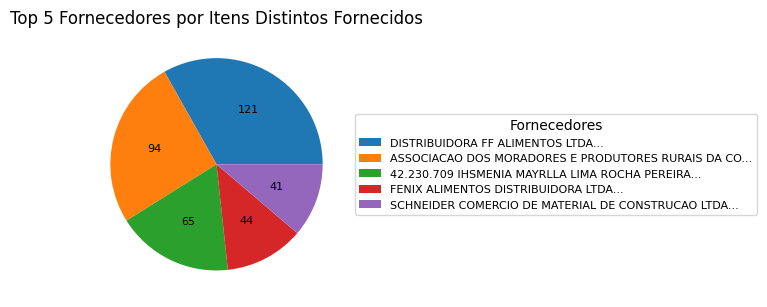

In [19]:
# Top 5 fornecedores por número de itens distintos fornecidos
df = fetch("""
SELECT
    f.cod_fornecedor,
    f.nome_fornecedor,
    COUNT(DISTINCT fi.cod_item_catalogo) AS num_itens_distintos
FROM Fornecedor f
INNER JOIN Fornecedor_item fi
  ON f.cod_fornecedor = fi.cod_fornecedor
GROUP BY
    f.cod_fornecedor,
    f.nome_fornecedor
ORDER BY
    num_itens_distintos DESC
LIMIT 5;
""", conn)

# Abrevia nome para legenda (até 50 caracteres + '...')
df['nome_legenda'] = df['nome_fornecedor'].str.slice(0, 50) + '...'
sizes = df['num_itens_distintos']

# Função para mostrar valor absoluto
def autopct_valores(pct):
    total = sizes.sum()
    val = int(round(pct * total / 100.0))
    return f"{val}"

# Gráfico de pizza
plt.figure()
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,
    autopct=autopct_valores,
    textprops={'fontsize': 8}
)
plt.legend(
    wedges,
    df['nome_legenda'],
    title='Fornecedores',
    bbox_to_anchor=(1, 0.5),
    loc='center left',
    fontsize=8
)
plt.title('Top 5 Fornecedores por Itens Distintos Fornecidos')
plt.tight_layout()
plt.show()

## 6.3 Consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6

In [20]:
# Código da compra, nome da unidade gestora e nome da modalidade
fetch("""
SELECT
    c.cod_compra,
    ug.unidade_orgao_nome_unidade,
    m.modalidade_nome
FROM Compra c
INNER JOIN Unidade_gestora ug
  ON c.unidade_orgao_codigo_unidade = ug.unidade_orgao_codigo_unidade
INNER JOIN Modalidade m
  ON c.modalidade_id = m.modalidade_id;
""", conn)

,cod_compra,unidade_orgao_nome_unidade,modalidade_nome
0,5494619,UNIVERSIDADE FEDERAL DE ALFENAS,Pregão - Eletrônico
1,5867782,COLEGIO MILITAR DE CAMPO GRANDE,Dispensa
2,5968630,PREFEITURA MUNICIPAL DE SARANDI - PR,Pregão - Eletrônico
3,6476796,AGÊNCIA BRAS.DE PROM.INTERNAC.DO TURISMO,Concorrência - Presencial
4,6733742,SECRETARIA DE EST.DE LICITAÇAO E CONTRATAÇAO,Concorrência - Presencial
...,...,...,...
3416,8727791,SECRETARIA DE ESTADO DA SAÚDE DE RR,Inexigibilidade
3417,8727839,PMSP - SECRETARIA MUNICIPAL DE CULTURA/SP,Dispensa
3418,8727863,5 REGIMENTO DE CAVALARIA MECANIZADO/RS,Dispensa
3419,8727964,PMSP - SECRETARIA MUNICIPAL DE CULTURA/SP,Inexigibilidade


### 6.3.2 Consulta 7

In [21]:
# Nome do fornecedor, item fornecido e descrição
fetch("""
SELECT
    f.nome_fornecedor,
    i.material_ou_servico_nome,
    i.cod_item_catalogo,
    i.descricao
FROM Fornecedor_item fi
INNER JOIN Fornecedor f
  ON fi.cod_fornecedor = f.cod_fornecedor
INNER JOIN Item i
  ON fi.cod_item_catalogo = i.cod_item_catalogo;
""", conn)

,nome_fornecedor,material_ou_servico_nome,cod_item_catalogo,descricao
0,TRENA AMAZONAS LTDA,Serviço,973,Sondagens Terrestres Rotativas Sondagens Terre...
1,MARANGON & MARANGON OFICINA MECANICA LTDA,Serviço,3620,Manutenção e Reparo de Máquinas de Escavação e...
2,BB GESTAO DE RECURSOS - DISTRIBUIDORA DE TITUL...,Serviço,3913,Desembaraço Alfandegário Desembaraço Alfandegário
3,CRISTIANE BORGUETTI MORAES LOPES,Serviço,3972,Leiloeiros Credenciamento de Leioleiros Creden...
4,TATIANA PAULA ZANI DE SOUSA,Serviço,3972,Leiloeiros Credenciamento de Leioleiros Creden...
...,...,...,...,...
4162,ERANORTE COMERCIO DE MADEIRAS LTDA,Material,627744,"Lâmpada Led tensão nominal: bivolt, potência n..."
4163,HEIDELBERG DO BRASIL SISTEMAS GRAFICOS E SERVI...,Material,627758,Peça / Componente - Equipamento Gráfico caract...
4164,MILLENA COMERCIO VAREJISTA DE MOVEIS E ELETRO ...,Material,628162,Estante Rack aplicação: rede de comunicação de...
4165,SOLANGE NASCIMENTO 27195495841,Material,628296,Vestuário Proteção características adicionais:...


### 6.3.3 Consulta 8

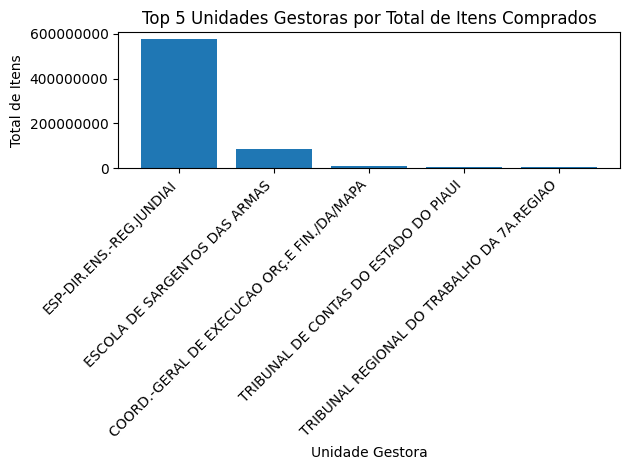

In [22]:
# unidades gestoras que compraram mais itens
df = fetch("""
SELECT
    ug.unidade_orgao_codigo_unidade AS unidade_orgao_codigo_unidade,
    ug.unidade_orgao_nome_unidade   AS unidade_nome,
    SUM(ic.quantidade)              AS total_itens
FROM Compra c
INNER JOIN Itens_compra ic
  ON c.cod_compra = ic.cod_compra
INNER JOIN Unidade_gestora ug
  ON c.unidade_orgao_codigo_unidade = ug.unidade_orgao_codigo_unidade
GROUP BY
    ug.unidade_orgao_codigo_unidade
ORDER BY
    total_itens DESC
LIMIT 5;
""", conn)

plt.figure()
plt.bar(df['unidade_nome'], df['total_itens'])
plt.xlabel('Unidade Gestora')
plt.ylabel('Total de Itens')
plt.title('Top 5 Unidades Gestoras por Total de Itens Comprados')
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


## 6.4 Consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9

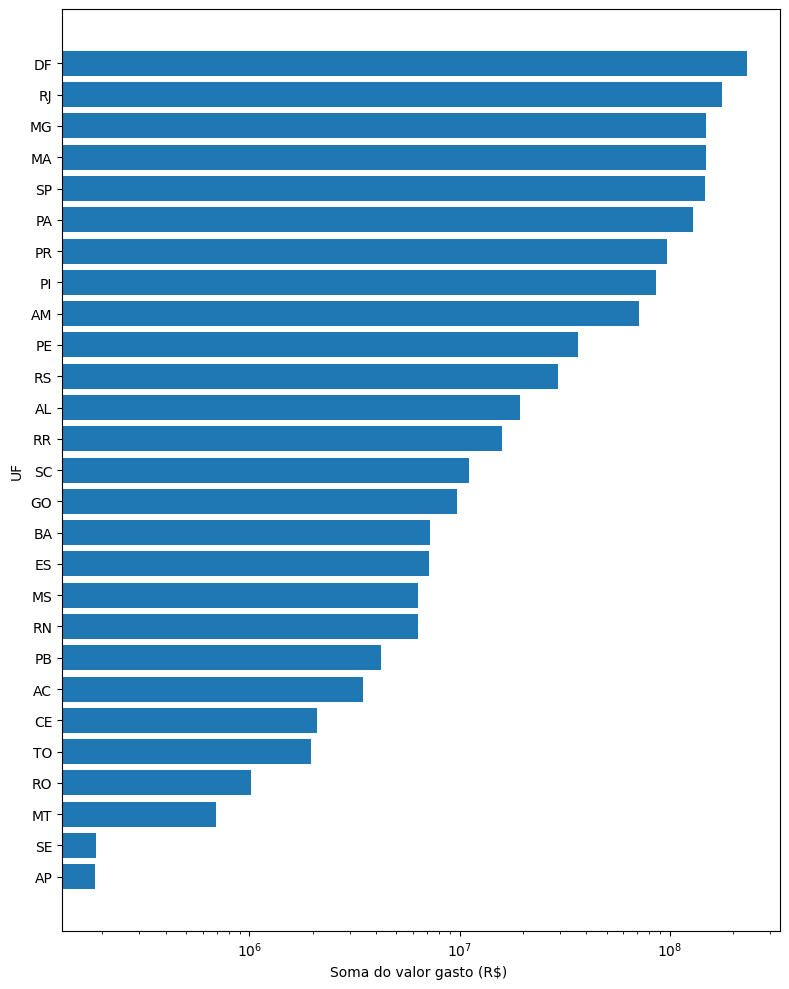

In [23]:
# Soma dos valores gastos por estado
distro = fetch(
    """
    SELECT
        ug.unidade_orgao_uf_sigla AS uf,
        SUM(c.valor_total_homologado) AS soma_valor_estimado
    FROM Compra c
    INNER JOIN Unidade_gestora ug
      ON c.unidade_orgao_codigo_unidade = ug.unidade_orgao_codigo_unidade
    GROUP BY ug.unidade_orgao_uf_sigla;
    """,
    conn,
    False
)

# ordena por valor
distro_sorted = sorted(distro, key=lambda x: x[1])
ufs   = [row[0] for row in distro_sorted]
somas = [row[1] for row in distro_sorted]

# gráfico de barras horizontais com escala log
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 10))
plt.barh(ufs, somas)
plt.xscale('log')
plt.xlabel('Soma do valor gasto (R$) ')
plt.ylabel('UF')
plt.tight_layout()
plt.show()

### 6.4.2 Consulta 10

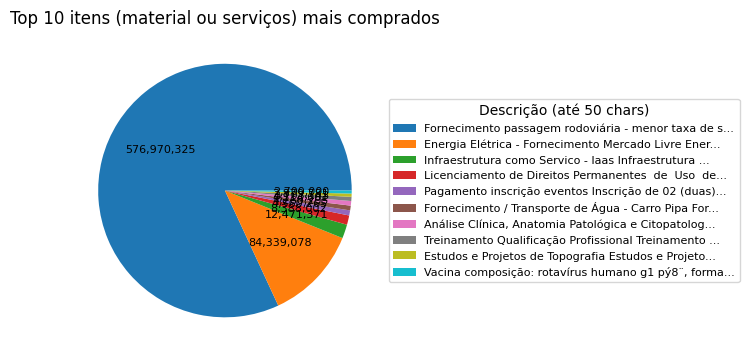

In [25]:
# Top 10 itens (materiais ou serviços) mais comprados e sua descricao
sql = """
SELECT
    i.cod_item_catalogo,
    i.descricao,
    i.material_ou_servico_nome,
    SUM(ic.quantidade) AS total_quantidade_comprada
FROM Itens_compra ic
INNER JOIN Item i
  ON ic.cod_item_catalogo = i.cod_item_catalogo
GROUP BY
    i.cod_item_catalogo,
    i.descricao,
    i.material_ou_servico_nome
ORDER BY
    total_quantidade_comprada DESC
LIMIT 10;
"""
df = fetch(sql, conn)

# Abrevia descrição a 50 caracteres e adiciona '...'
df['desc_lim'] = df['descricao'].str[:50] + '...'

sizes = df['total_quantidade_comprada']

# Função para mostrar valor absoluto
def autopct_valores(pct):
    total = sizes.sum()
    val = int(round(pct * total / 100.0))
    return f"{val:,}"

# Gráfico de pizza
plt.figure()
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct=autopct_valores,
    textprops={'fontsize': 8}
)
plt.legend(
    wedges,
    df['desc_lim'],
    title='Descrição (até 50 chars)',
    bbox_to_anchor=(1, 0.5),
    loc='center left',
    fontsize=8
)
plt.title('Top 10 itens (material ou serviços) mais comprados')
plt.tight_layout()
plt.show()

# 7. Autoavaliação

Daniel - Participei de todas as etapas do trabalho. Fizemos junto as interpretações dos dados e modelagem. Em relação ao código atuei mais focado na parte de ingestão dos dados, limpeza, criação do esquema no banco além de garantir que algumas consultas tivessem gráficos. Por fim, fiz os slides também.

Diego - Atuei principalmente na análise e intepretação dos dados para decisão das modelagens, realização da modelagem do Diagrama Entidade-Relacionamento, modelagem do Esquema Relacional e implementação das consultas.

Gabriel - Participei na análise e interpretação dos dados do banco de dados, na montagem do Diagrama Entidade-Relacionamento e na modelagem do Esquema Relacional.